# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters

In [3]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [4]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [5]:
params = vaep.nb.get_params(args, globals=globals())
params

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


{'folder_data': '',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'folder_experiment': 'runs/alzheimer_study',
 'model_key': 'QRILC',
 'target': 'AD',
 'sample_id_col': 'Sample ID',
 'cutoff_target': 0.5,
 'file_format': 'csv',
 'out_folder': 'diff_analysis',
 'fn_qc_samples': '',
 'baseline': 'PI',
 'template_pred': 'pred_real_na_{}.csv'}

In [6]:
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
args

root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

In [7]:
files_out = dict()

## Load target

In [8]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### Measured data

In [9]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                          
Sample_005  Q15582                                     19.262
Sample_098  O43291                                     17.357
Sample_017  Q9UM22                                     16.586
Sample_118  Q9UI40;Q9UI40-2                            16.271
Sample_060  H3BMA1;H3BUX1;Q13421-2;Q13421-3;Q13421-4   15.895
Name: intensity, dtype: float64

Get overlap between independent features and target

### Load ALD data or create

In [10]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [11]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load semi-supervised model imputations

In [12]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                                                                          
Sample_045  O95297;O95297-2;O95297-3;O95297-4;Q9UEL6                                                   14.137
Sample_098  Q96IU4                                                                                     12.846
Sample_049  C9IY66;C9JNC3;H7BYC3;Q7KYR7;Q7KYR7-1;Q7KYR7-4;Q7KYR7-5;Q7KYR7-6;Q8WVV5;Q8WVV5-2;Q8WVV5-3   12.797
Name: intensity, dtype: float64

In [13]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.625
            A0A075B6Q5                 12.870
            A0A075B6R2                 12.220
            A0A075B6S5                 12.145
            A0A087WSY4                 12.357
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.762
            Q9UI40;Q9UI40-2            13.981
            Q9UIW2                     12.220
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.847
            Q9UP79                     11.736
Name: intensity, Length: 46401, dtype: float64

## Model predictions
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
3. newly available feat only: the subset of features available from the
self supervised deep learning model which were newly retained using the
new approach

In [14]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.175,15.050,16.842,19.863,14.165,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,13.894,19.067,...,15.528,15.576,11.908,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.444,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.453,17.705,17.039,13.833,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,11.420,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.609,15.345,17.084,18.708,14.249,19.433,8.557,8.220
Sample_207,15.739,16.877,15.469,16.898,14.307,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [15]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.625,...,16.012,15.178,12.882,15.050,16.842,19.863,13.460,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.456,19.067,16.188,...,15.528,15.576,11.165,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.648,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.387,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.224,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.818,15.345,17.084,18.708,14.249,19.433,13.420,12.056
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [16]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification


In [17]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Best number of parameters by CV

In [18]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 353.06it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.76it/s]

100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.94it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.05it/s]

100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.68it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.88it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.32it/s]

100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.38it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.24it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.67it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.32it/s]

100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.98it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.13it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.79it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.35it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.10it/s]

100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.10it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.63it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.78it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.38it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.29it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.58it/s]

100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

100%|██████████| 8/8 [00:02<00:00,  2.77it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.13it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.52it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.92it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.70it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.48it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.13it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.96it/s]

100%|██████████| 9/9 [00:03<00:00,  2.09it/s]

100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.23it/s]

 30%|███       | 3/10 [00:00<00:02,  2.97it/s]

 40%|████      | 4/10 [00:01<00:02,  2.55it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.36it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.31it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.34it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.22it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.13it/s]

100%|██████████| 10/10 [00:04<00:00,  2.13it/s]

100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.71it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.25it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.66it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.41it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.24it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.02it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.53it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.34it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.22it/s]

100%|██████████| 11/11 [00:03<00:00,  2.35it/s]

100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.58it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.45it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.91it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.55it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.56it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.10it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.90it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.79it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.76it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.87it/s]

100%|██████████| 12/12 [00:05<00:00,  2.04it/s]

100%|██████████| 12/12 [00:05<00:00,  2.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.60it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.66it/s]

 31%|███       | 4/13 [00:01<00:03,  2.29it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.02it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.90it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.87it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.79it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.99it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.12it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.23it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.33it/s]

100%|██████████| 13/13 [00:05<00:00,  2.48it/s]

100%|██████████| 13/13 [00:05<00:00,  2.22it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.95it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.71it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.25it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.07it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.01it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.46it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.22it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.14it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.17it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.22it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.36it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.45it/s]

100%|██████████| 14/14 [00:05<00:00,  2.54it/s]

100%|██████████| 14/14 [00:05<00:00,  2.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.71it/s]

 20%|██        | 3/15 [00:00<00:03,  3.75it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.48it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.29it/s]

 40%|████      | 6/15 [00:01<00:02,  3.36it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.74it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.39it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.31it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.31it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.43it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.55it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.58it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.37it/s]

100%|██████████| 15/15 [00:05<00:00,  2.16it/s]

100%|██████████| 15/15 [00:05<00:00,  2.59it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.007      0.075 0.037          0.650 0.423       0.091   
2             0.005 0.004      0.062 0.022          0.616 0.145       0.451   
3             0.005 0.004      0.059 0.024          0.804 0.082       0.732   
4             0.005 0.003      0.064 0.022          0.793 0.081       0.772   
5             0.004 0.002      0.056 0.017          0.800 0.089       0.802   
6             0.006 0.005      0.064 0.028          0.800 0.091       0.806   
7             0.005 0.003      0.068 0.027          0.813 0.087       0.812   
8             0.006 0.004      0.066 0.024          0.808 0.088       0.804   
9             0.005 0.003      0.062 0.028          0.856 0.080       0.820   
10            0.005 0.003      0.056 0.022          0.854 0.086       0.819   
11            0.006 0.005      0.081 0.033          0.850 0.073       0.824   
12            0.005 0.003      0.060 0.023          0.845 0.077       0.828   
13            0.005 0.003      0.060 0.020          0.841 0.075       0.819   
14            0.007 0.006      0.077 0.033          0.837 0.076       0.819   
15            0.007 0.006      0.076 0.035          0.842 0.075       0.818   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.153 0.127                  0.538 0.039        0.851   
2          0.112   0.510 0.100                  0.615 0.070        0.694   
3          0.094   0.762 0.071                  0.799 0.056        0.911   
4          0.111   0.777 0.075                  0.811 0.062        0.914   
5          0.115   0.795 0.077                  0.826 0.064        0.917   
6          0.114   0.797 0.078                  0.827 0.065        0.915   
7          0.101   0.808 0.074                  0.836 0.062        0.916   
8          0.099   0.802 0.072                  0.830 0.061        0.914   
9          0.088   0.833 0.065                  0.858 0.054        0.929   
10         0.091   0.832 0.067                  0.856 0.056        0.927   
11         0.089   0.834 0.063                  0.858 0.053        0.930   
12         0.096   0.833 0.072                  0.858 0.061        0.928   
13         0.095   0.826 0.069                  0.852 0.058        0.927   
14         0.095   0.824 0.067                  0.850 0.057        0.926   
15         0.093   0.827 0.069                  0.852 0.058        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.824 0.090        210.000 0.000  
2          0.087                  0.648 0.101        210.000 0.000  
3          0.042                  0.896 0.045        210.000 0.000  
4          0.042                  0.897 0.049        210.000 0.000  
5          0.042                  0.903 0.047        210.000 0.000  
6          0.043                  0.902 0.047        210.000 0.000  
7          0.044                  0.904 0.047        210.000 0.000  
8          0.044                  0.902 0.047        210.000 0.000  
9          0.042                  0.921 0.043        210.000 0.000  
10         0.044                  0.915 0.049        210.000 0.000  
11         0.045                  0.919 0.048        210.000 0.000  
12         0.045                  0.917 0.047        210.000 0.000  
13         0.045                  0.915 0.048        210.000 0.000  
14         0.045                  0.914 0.047        210.000 0.000  
15         0.043                  0.911 0.047 

In [19]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 452.56it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.45it/s]

100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.79it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.45it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.23it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.29it/s]

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.76it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.19it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.76it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.32it/s]

100%|██████████| 6/6 [00:02<00:00,  1.92it/s]

100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.63it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.72it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.20it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.12it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.56it/s]

100%|██████████| 7/7 [00:02<00:00,  2.17it/s]

100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.54it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.78it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.17it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.86it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.80it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.44it/s]

100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

100%|██████████| 8/8 [00:03<00:00,  2.61it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.40it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.51it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.14it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.05it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.95it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.49it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.23it/s]

100%|██████████| 9/9 [00:03<00:00,  2.14it/s]

100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.74it/s]

 30%|███       | 3/10 [00:00<00:01,  3.80it/s]

 40%|████      | 4/10 [00:01<00:01,  3.34it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.08it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.95it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.43it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.14it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.01it/s]

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.88it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.04it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.42it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.18it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.04it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.90it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.41it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.35it/s]

 91%|█████████ | 10/11 [00:03<00:00,  1.95it/s]

100%|██████████| 11/11 [00:04<00:00,  1.93it/s]

100%|██████████| 11/11 [00:04<00:00,  2.49it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.15it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.40it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.98it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.91it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.75it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.11it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.79it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.77it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.83it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.96it/s]

100%|██████████| 12/12 [00:05<00:00,  2.10it/s]

100%|██████████| 12/12 [00:05<00:00,  2.24it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.29it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.80it/s]

 31%|███       | 4/13 [00:01<00:02,  3.37it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.17it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.69it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.12it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.85it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.93it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.99it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.13it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.16it/s]

100%|██████████| 13/13 [00:05<00:00,  2.15it/s]

100%|██████████| 13/13 [00:05<00:00,  2.34it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.64it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.41it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.09it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.31it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.08it/s]

 50%|█████     | 7/14 [00:02<00:03,  1.98it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.01it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.14it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.21it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.32it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.37it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.43it/s]

100%|██████████| 14/14 [00:05<00:00,  2.46it/s]

100%|██████████| 14/14 [00:05<00:00,  2.40it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.61it/s]

 20%|██        | 3/15 [00:00<00:03,  3.69it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.07it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.88it/s]

 40%|████      | 6/15 [00:01<00:03,  2.73it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.30it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.21it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.02it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.01it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.09it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.21it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.33it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.34it/s]

100%|██████████| 15/15 [00:06<00:00,  2.37it/s]

100%|██████████| 15/15 [00:06<00:00,  2.43it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.005      0.078 0.026          0.828 0.279       0.125   
2             0.004 0.002      0.070 0.029          0.613 0.118       0.471   
3             0.006 0.006      0.076 0.033          0.818 0.086       0.726   
4             0.005 0.004      0.068 0.026          0.814 0.078       0.764   
5             0.006 0.006      0.057 0.032          0.810 0.078       0.752   
6             0.007 0.006      0.074 0.031          0.810 0.080       0.753   
7             0.006 0.005      0.075 0.030          0.835 0.087       0.779   
8             0.006 0.004      0.067 0.027          0.834 0.089       0.772   
9             0.005 0.004      0.059 0.023          0.813 0.081       0.835   
10            0.005 0.005      0.056 0.019          0.821 0.079       0.824   
11            0.005 0.003      0.058 0.019          0.822 0.078       0.821   
12            0.006 0.008      0.060 0.022          0.810 0.078       0.822   
13            0.007 0.007      0.060 0.018          0.828 0.079       0.825   
14            0.005 0.003      0.054 0.015          0.825 0.078       0.823   
15            0.007 0.006      0.095 0.032          0.804 0.078       0.818   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.079   0.209 0.118                  0.554 0.039        0.851   
2          0.116   0.524 0.099                  0.624 0.066        0.706   
3          0.100   0.765 0.073                  0.803 0.059        0.901   
4          0.109   0.783 0.072                  0.817 0.059        0.902   
5          0.111   0.774 0.074                  0.810 0.059        0.898   
6          0.111   0.776 0.076                  0.811 0.061        0.896   
7          0.104   0.801 0.074                  0.831 0.061        0.908   
8          0.100   0.797 0.073                  0.828 0.060        0.906   
9          0.104   0.820 0.074                  0.846 0.065        0.915   
10         0.103   0.819 0.070                  0.845 0.061        0.918   
11         0.105   0.817 0.069                  0.844 0.060        0.918   
12         0.103   0.812 0.072                  0.840 0.063        0.915   
13         0.094   0.823 0.066                  0.849 0.056        0.918   
14         0.092   0.820 0.065                  0.847 0.056        0.915   
15         0.091   0.807 0.059                  0.834 0.051        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.824 0.088        210.000 0.000  
2          0.080                  0.657 0.097        210.000 0.000  
3          0.050                  0.882 0.059        210.000 0.000  
4          0.050                  0.883 0.057        210.000 0.000  
5          0.053                  0.879 0.060        210.000 0.000  
6          0.054                  0.878 0.060        210.000 0.000  
7          0.054                  0.892 0.061        210.000 0.000  
8          0.055                  0.891 0.061        210.000 0.000  
9          0.050                  0.902 0.053        210.000 0.000  
10         0.050                  0.907 0.052        210.000 0.000  
11         0.050                  0.907 0.052        210.000 0.000  
12         0.050                  0.905 0.051        210.000 0.000  
13         0.050                  0.909 0.052        210.000 0.000  
14         0.050                  0.906 0.052        210.000 0.000  
15         0.047                  0.900 0.051 

In [20]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 894.12it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 19.01it/s]

100%|██████████| 2/2 [00:00<00:00, 15.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 14.52it/s]

100%|██████████| 3/3 [00:00<00:00, 14.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 14.35it/s]

100%|██████████| 4/4 [00:00<00:00, 13.39it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.09it/s]

100%|██████████| 5/5 [00:00<00:00, 13.83it/s]

100%|██████████| 5/5 [00:00<00:00, 14.07it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 18.97it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 11.77it/s]

100%|██████████| 6/6 [00:00<00:00,  9.91it/s]

100%|██████████| 6/6 [00:00<00:00, 10.49it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.82it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.71it/s]

100%|██████████| 7/7 [00:00<00:00, 16.69it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.10it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.73it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.78it/s]

100%|██████████| 8/8 [00:00<00:00, 13.61it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 19.44it/s]

 44%|████▍     | 4/9 [00:00<00:00, 10.92it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  9.72it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 10.04it/s]

100%|██████████| 9/9 [00:00<00:00, 10.50it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.79it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.72it/s]

 70%|███████   | 7/10 [00:00<00:00, 14.96it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.76it/s]

100%|██████████| 10/10 [00:00<00:00, 14.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.57it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.70it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.06it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.07it/s]

100%|██████████| 11/11 [00:00<00:00, 10.97it/s]

100%|██████████| 11/11 [00:00<00:00, 11.57it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 17.79it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.64it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.69it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.35it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 10.13it/s]

100%|██████████| 12/12 [00:01<00:00, 10.24it/s]

100%|██████████| 12/12 [00:01<00:00, 10.26it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.36it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.19it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 12.67it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.14it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.37it/s]

100%|██████████| 13/13 [00:01<00:00, 12.73it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 13.50it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.60it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.04it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 10.61it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 11.51it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 11.47it/s]

100%|██████████| 14/14 [00:01<00:00, 12.05it/s]

100%|██████████| 14/14 [00:01<00:00, 11.31it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 19.61it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.89it/s]

 40%|████      | 6/15 [00:00<00:00,  9.17it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.91it/s]

 67%|██████▋   | 10/15 [00:00<00:00,  9.87it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.92it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.28it/s]

100%|██████████| 15/15 [00:01<00:00,  9.40it/s]

100%|██████████| 15/15 [00:01<00:00,  9.62it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.060 0.023          0.000 0.000       0.000   
2             0.006 0.005      0.073 0.030          0.693 0.171       0.378   
3             0.006 0.005      0.079 0.029          0.628 0.136       0.361   
4             0.006 0.007      0.070 0.033          0.636 0.121       0.384   
5             0.005 0.003      0.049 0.010          0.570 0.123       0.397   
6             0.005 0.004      0.065 0.023          0.557 0.120       0.390   
7             0.005 0.004      0.069 0.027          0.537 0.123       0.359   
8             0.005 0.003      0.052 0.017          0.558 0.119       0.384   
9             0.004 0.003      0.053 0.020          0.516 0.109       0.380   
10            0.007 0.006      0.106 0.040          0.508 0.111       0.380   
11            0.006 0.005      0.071 0.030          0.503 0.104       0.382   
12            0.005 0.003      0.070 0.027          0.502 0.116       0.382   
13            0.007 0.005      0.089 0.026          0.547 0.096       0.435   
14            0.005 0.003      0.066 0.033          0.548 0.104       0.446   
15            0.004 0.001      0.055 0.017          0.620 0.092       0.563   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.703   
2          0.088   0.477 0.089                  0.617 0.066        0.647   
3          0.084   0.450 0.082                  0.596 0.057        0.644   
4          0.100   0.469 0.085                  0.607 0.053        0.661   
5          0.110   0.460 0.096                  0.586 0.065        0.636   
6          0.107   0.452 0.097                  0.580 0.063        0.623   
7          0.102   0.423 0.096                  0.564 0.061        0.613   
8          0.115   0.447 0.107                  0.580 0.069        0.605   
9          0.105   0.432 0.096                  0.560 0.060        0.609   
10         0.109   0.428 0.102                  0.556 0.064        0.601   
11         0.110   0.429 0.102                  0.555 0.062        0.593   
12         0.113   0.428 0.108                  0.554 0.069        0.581   
13         0.118   0.480 0.104                  0.589 0.065        0.622   
14         0.117   0.488 0.106                  0.592 0.070        0.642   
15         0.129   0.583 0.096                  0.655 0.071        0.701   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.073                  0.664 0.091        210.000 0.000  
2          0.080                  0.601 0.092        210.000 0.000  
3          0.080                  0.591 0.092        210.000 0.000  
4          0.085                  0.591 0.090        210.000 0.000  
5          0.079                  0.576 0.083        210.000 0.000  
6          0.079                  0.563 0.084        210.000 0.000  
7          0.077                  0.555 0.082        210.000 0.000  
8          0.083                  0.545 0.080        210.000 0.000  
9          0.077                  0.539 0.078        210.000 0.000  
10         0.083                  0.534 0.080        210.000 0.000  
11         0.084                  0.527 0.079        210.000 0.000  
12         0.082                  0.523 0.076        210.000 0.000  
13         0.083                  0.551 0.076        210.000 0.000  
14         0.075                  0.577 0.077        210.000 0.000  
15         0.071                  0.663 0.086 

In [21]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,15,13
score_time,11,15,10
test_precision,9,7,2
test_recall,12,9,15
test_f1,11,13,15
test_balanced_accuracy,11,13,15
test_roc_auc,11,13,1
test_average_precision,9,13,1
n_observations,1,1,1


## Train, test split

In [22]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

In [23]:
njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


In [24]:
y_train.value_counts()

AD   
False   98
True    70
Name: count, dtype: int64

## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

In [25]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:04,  2.57it/s]

 23%|██▎       | 3/13 [00:01<00:05,  1.78it/s]

 31%|███       | 4/13 [00:02<00:05,  1.58it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.68it/s]

 46%|████▌     | 6/13 [00:03<00:03,  1.84it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.83it/s]

 62%|██████▏   | 8/13 [00:04<00:02,  1.82it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.93it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.99it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.97it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  2.00it/s]

100%|██████████| 13/13 [00:06<00:00,  2.04it/s]

100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

In [26]:
# all(results_model_full.test.roc.tpr
#     ==
#     vaep.sklearn.Results.from_pickle(fname).test.roc.tpr)

In [27]:
splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 930.62it/s]

In [28]:
splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.30it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.01it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.91it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.04it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.09it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.39it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.06it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.93it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.86it/s]

100%|██████████| 11/11 [00:04<00:00,  1.93it/s]

100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

### ROC-AUC

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


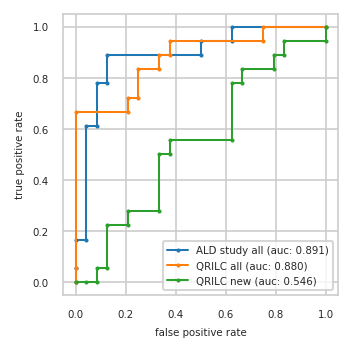

In [29]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [30]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.167     0.000 0.667     0.083 0.000
3          0.042 0.167     0.208 0.667     0.083 0.056
4          0.042 0.611     0.208 0.722     0.125 0.056
5          0.083 0.611     0.250 0.722     0.125 0.222
6          0.083 0.778     0.250 0.833     0.208 0.222
7          0.125 0.778     0.333 0.833     0.208 0.278
8          0.125 0.889     0.333 0.889     0.333 0.278
9          0.500 0.889     0.375 0.889     0.333 0.500
10         0.500 0.944     0.375 0.944     0.375 0.500
11         0.625 0.944     0.750 0.944     0.375 0.556
12         0.625 1.000     0.750 1.000     0.625 0.556
13         1.000 1.000     1.000 1.000     0.625 0.778
14           NaN   NaN       NaN   NaN     0.667 0.778
15           NaN   NaN       NaN   NaN     0.667 0.833
16           NaN   NaN       NaN   NaN     0.792 0.833
17           NaN   NaN       NaN   NaN     0.792 0.889
18           NaN   NaN       NaN   NaN     0.833 0.889
19           NaN   NaN       NaN   NaN     0.833 0.944
20           NaN   NaN       NaN   NaN     1.000 0.944
21           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected

In [31]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
1,Q9P2E7;Q9P2E7-2,P60709;P63261,None
2,P01597;P04432,K7EIS2;K7EKV3;K7EM70;K7EQL9;Q9BSG5;Q9BSG5-2;Q9...,None
3,P61981,P10636-2;P10636-6,None
4,P04075,A0A0B4J1V0,None
5,P14174,P61981,None
6,P00338;P00338-3,P04075,None
7,Q02818,P14174,None
8,Q9Y2T3;Q9Y2T3-3,P08294,None


### Precision-Recall plot

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


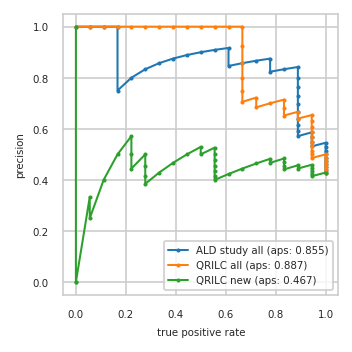

In [32]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [33]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.415 0.944
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.486 0.944     0.457 0.889
8          0.529 1.000     0.500 0.944     0.441 0.833
9          0.545 1.000     0.515 0.944     0.455 0.833
10         0.531 0.944     0.531 0.944     0.469 0.833
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.567 0.944     0.567 0.944     0.467 0.778
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.571 0.889     0.607 0.944     0.464 0.722
15         0.593 0.889     0.630 0.944     0.444 0.667
16         0.615 0.889     0.654 0.944     0.423 0.611
17         0.640 0.889     0.640 0.889     0.400 0.556
18         0.667 0.889     0.667 0.889     0.417 0.556
19         0.696 0.889     0.652 0.833     0.435 0.556
20         0.727 0.889     0.682 0.833     0.455 0.556
21         0.762 0.889     0.714 0.833     0.476 0.556
22         0.800 0.889     0.700 0.778     0.500 0.556
23         0.842 0.889     0.684 0.722     0.526 0.556
24         0.833 0.833     0.722 0.722     0.500 0.500
25         0.824 0.778     0.706 0.667     0.529 0.500
26         0.875 0.778     0.750 0.667     0.500 0.444
27         0.867 0.722     0.800 0.667     0.467 0.389
28         0.857 0.667     0.857 0.667     0.429 0.333
29         0.846 0.611     0.923 0.667     0.385 0.278
30         0.917 0.611     1.000 0.667     0.417 0.278
31         0.909 0.556     1.000 0.611     0.455 0.278
32         0.900 0.500     1.000 0.556     0.500 0.278
33         0.889 0.444     1.000 0.500     0.444 0.222
34         0.875 0.389     1.000 0.444     0.500 0.222
35         0.857 0.333     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


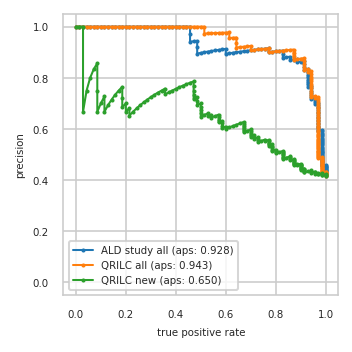

In [34]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


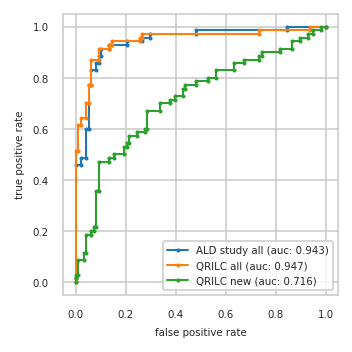

In [35]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Options:
- F1 results for test data for best cutoff on training data?
  (select best cutoff of training data, evaluate on test data)
- plot X_train PCA/UMAP, map X_test

In [36]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}